# A+logorithms

## Introduction
This notebook aims to deepen my knowledge on regression and classification predictive modelling and thus some steps may be uneccessary for the final analysis but are included for experimentation and exploratory learning.

Overall, the main aim is to predict student's performance based on their age, weekly study time, total abences and if parential support is present. 

## Questions of Interest
1. which classification algorithm performs better for predicting student's letter grade between support vector machine (SVM) or  random forest

2. would using regression algorithm to predict GPA and then converting it to letter grade produce a higher accurancy than directly using classification model to predict the letter grade?


## Imports

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Data Cleaning and Preparation

First we need to change all currnet grade class value from numeric grade to letter grade

In [52]:
student_list = pd.read_csv('Student_List.csv')

# initiate mapping dictionary 
gpa_mapping = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'F',
}

# make a new copy of the dataframe
student_list_clean = student_list.copy()

# change all values in 'GradeClass' based on mapping dictionary
student_list_clean['GradeClass'] = student_list_clean['GradeClass'].map(gpa_mapping)
student_list_clean


,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,B
1,1003,15,4.210570,26,2,0.112602,F
2,1004,17,10.028829,14,3,2.054218,D
3,1005,17,4.672495,17,3,1.288061,F
4,1006,18,8.191219,0,1,3.084184,B
...,...,...,...,...,...,...,...
2095,3386,16,1.445434,20,3,1.395631,B
2096,3388,18,10.680555,2,4,3.455509,A
2097,3390,16,6.805500,20,2,1.142333,C
2098,3391,16,12.416653,17,2,1.803297,B


Check if there are any missing values from the dataset

In [53]:
# calculate if there is any missing values
missing_value = student_list_clean.isna().sum().reset_index()

# display results in a dataframe
missing_value.columns = ['Columns', 'Number of Missing Values']
missing_value

,Columns,Number of Missing Values
0,StudentID,0
1,Age,0
2,StudyTimeWeekly,21
3,Absences,0
4,ParentalSupport,0
5,GPA,0
6,GradeClass,0


From this we can see that there are missing values specifically, in the StudyTimeWeekly column with 21 missing values. Thus, we will fill the empty columns with the median value of StudyTimeWeekly column

In [54]:
# calculate median of column 'StudyTimeWeekly'
col_median = student_list_clean['StudyTimeWeekly'].median()

# fill all missing values with the median
student_list_clean['StudyTimeWeekly'] = student_list_clean['StudyTimeWeekly'].fillna(col_median)

Find any outliers in the 'Absences' column by using the IQR method to calculate the upper and lower bound, any data that are beyond this bound is considered an outlier.

In [55]:
# function for finding rows that have outliers for a specified column
Q1 = student_list_clean['Absences'].quantile(0.25)
Q3 = student_list_clean['Absences'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = student_list_clean[(student_list_clean['Absences'] < lower_bound) | (student_list_clean['Absences'] > upper_bound)]

# Detecting outliers for each column
outliers.reset_index(drop=True)

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1114,16,16.849282,320,1,1.919956,F
1,2003,15,0.806505,-122,3,3.201710,B


We can see that there are 2 outliers in the 'Absences' column, the solution is the simply drop the rows that contains these outliers

In [56]:
# drop outliers from the dataframe
student_list_clean = student_list_clean.drop(outliers.index).reset_index(drop=True)
student_list_clean

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,B
1,1003,15,4.210570,26,2,0.112602,F
2,1004,17,10.028829,14,3,2.054218,D
3,1005,17,4.672495,17,3,1.288061,F
4,1006,18,8.191219,0,1,3.084184,B
...,...,...,...,...,...,...,...
2093,3386,16,1.445434,20,3,1.395631,B
2094,3388,18,10.680555,2,4,3.455509,A
2095,3390,16,6.805500,20,2,1.142333,C
2096,3391,16,12.416653,17,2,1.803297,B


check if all GPA is mapped to the correct grade class and creating a dataframe of rows that are not correctly mapped.

In [57]:
# create function to check if GPA correspond to the correct grade
# returns true if correct, if not false
def classify_grade(row):
    gradeclass, gpa = row['GradeClass'], row['GPA']
    if gradeclass == 'A':
        return gpa >= 3.5
    elif gradeclass == 'B':
        return 3.0 <= gpa < 3.5
    elif gradeclass == 'C':
        return 2.5 <= gpa < 3.0
    elif gradeclass == 'D':
        return 2.0 <= gpa < 2.5
    else:
        return gpa < 2.0

student_list_clean_test = student_list_clean.copy()
# Apply the function to each row of the DataFrame, creating a new 'IsCorrectGrade' column
student_list_clean_test['IsCorrectGrade'] = student_list_clean_test.apply(classify_grade, axis=1)

# get rows where 'IsCorrectGrade'is false
incorrect_rows = student_list_clean_test[student_list_clean_test['IsCorrectGrade'] == False]
incorrect_rows

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass,IsCorrectGrade
1998,3182,15,3.253044,13,1,1.844056,B,False
1999,3183,17,17.086920,25,2,1.305585,C,False
2000,3189,16,5.697054,9,1,2.459805,B,False
2001,3193,16,15.827054,28,1,0.818126,C,False
2002,3195,15,15.615710,26,3,1.174610,A,False
...,...,...,...,...,...,...,...,...
2093,3386,16,1.445434,20,3,1.395631,B,False
2094,3388,18,10.680555,2,4,3.455509,A,False
2095,3390,16,6.805500,20,2,1.142333,C,False
2096,3391,16,12.416653,17,2,1.803297,B,False


From the table above we can see that not all GPA is mapped to the correct grade class thus we need to iterate through and make all rows have the correct grade class based on student's GPA.

In [58]:
# create a method to map each GPA to their correct corresponding GradeClass
def grade_classifier(row):
    gradeclass, gpa = row['GradeClass'], row['GPA']
    if gpa >= 3.5:
        return 'A'
    elif 3.0 <= gpa < 3.5:
        return 'B'
    elif 2.5 <= gpa < 3.0:
        return 'C'
    elif 2.0 <= gpa < 2.5:
        return 'D'
    else:
        return 'F'
        
# Apply the function to each row of the DataFrame
student_list_clean.loc[:,'GradeClass'] = student_list_clean.apply(grade_classifier, axis=1)
student_list_clean

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,B
1,1003,15,4.210570,26,2,0.112602,F
2,1004,17,10.028829,14,3,2.054218,D
3,1005,17,4.672495,17,3,1.288061,F
4,1006,18,8.191219,0,1,3.084184,B
...,...,...,...,...,...,...,...
2093,3386,16,1.445434,20,3,1.395631,F
2094,3388,18,10.680555,2,4,3.455509,B
2095,3390,16,6.805500,20,2,1.142333,F
2096,3391,16,12.416653,17,2,1.803297,F


## Classification Model: Training

Spliting data into training and test dataset

In [59]:
from sklearn.model_selection import train_test_split

# assign coresponding columns to respective variables
x = student_list_clean[['Age', 'StudyTimeWeekly', 'Absences', 'ParentalSupport']]
y = student_list_clean['GradeClass']

# split data for training and testing  
# used stratify=y preserves the proportion of classes from the original dataset in both training and test sets
x_train, x_test, y_train, y_test = train_test_split(
 x, y, test_size = 0.2, random_state = 0, stratify=y
)

perform feature scaling to normalise the dataset

In [60]:
# Feature Scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

Creating a predictive SMV model

In [61]:
# initialise support vector classification with linear kernal
svm_model = SVC(kernel='linear')

# fitting model with the training data
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

Create random forest algorithm model

In [62]:
# initialise random forest algorithm
classifier = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'entropy',
    random_state = 0
)
# fitting model with the training data
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

## Classification Model: Testing

Using the model created, predicting the GradeClass of the test data

In [63]:
# predict output with test data for smv and tree model 
y_pred_svm = svm_model.predict(x_test)
y_pred_forest = classifier.predict(x_test)

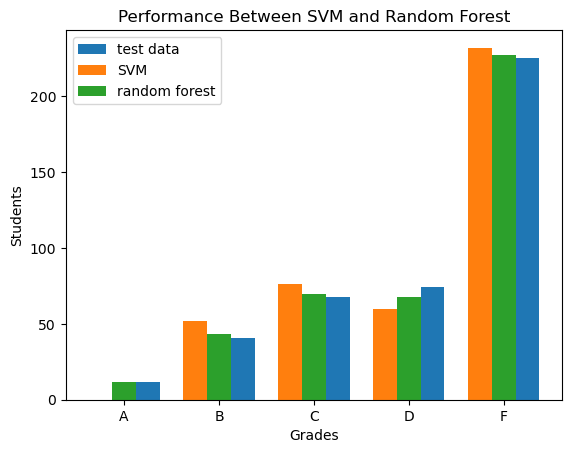

In [64]:
labels = ['A', 'B', 'C', 'D', 'F']
svm_values = [np.sum(y_pred_svm == label) for label in labels]
forest_values = [np.sum(y_pred_forest == label) for label in labels]
y_test_values = [np.sum(y_test == label) for label in labels]

x = np.arange(len(labels))
width = 0.25

plt.bar(x + width, y_test_values, width, label='test data')
plt.bar(x - width, svm_values, width, label='SVM')
plt.bar(x, forest_values, width, label='random forest')

plt.title('Performance Between SVM and Random Forest')
plt.xlabel('Grades')
plt.ylabel('Students')
plt.xticks(x, labels)
plt.legend()
plt.show()

In [65]:
# construct 5x5 confusion matrix
# label for each grade class
label = ['A', 'B', 'C', 'D', 'F']

# constructing confusion matrix
svm_cm = confusion_matrix(y_test, y_pred_svm, labels = label)
forest_cm = confusion_matrix(y_test, y_pred_forest, labels = label)
print(f'SVM confusion matrix \n {svm_cm}')
print()
print(f'Forest confusion matrix \n {forest_cm}')


SVM confusion matrix 
 [[  0  12   0   0   0]
 [  0  28  13   0   0]
 [  0  12  42  11   3]
 [  0   0  20  39  15]
 [  0   0   1  10 214]]

Forest confusion matrix 
 [[  5   7   0   0   0]
 [  5  19  17   0   0]
 [  2  17  30  17   2]
 [  0   0  22  33  19]
 [  0   0   1  18 206]]


In [66]:
# print accuracy of SVM and tree model

print('Accurancy of SVM')
print(accuracy_score(y_test, y_pred_svm))

print('\nAccurancy of tree')
print(accuracy_score(y_test, y_pred_forest))

Accurancy of SVM
0.7690476190476191

Accurancy of tree
0.6976190476190476


Although from the bar graph random forest appears to perform better, the calculated accuracy of random forest is 0.698 which is lower than SVM standing at 0.769. From the confusion matrix, we can further inspect the performance of each algorithm and their behaviour. 

Overall, in the context of predicting student grades, SVM demostrated better performace compared to random forest algorithm.

## Regression Model: Training and Testing

In [67]:
student_list_clean

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,B
1,1003,15,4.210570,26,2,0.112602,F
2,1004,17,10.028829,14,3,2.054218,D
3,1005,17,4.672495,17,3,1.288061,F
4,1006,18,8.191219,0,1,3.084184,B
...,...,...,...,...,...,...,...
2093,3386,16,1.445434,20,3,1.395631,F
2094,3388,18,10.680555,2,4,3.455509,B
2095,3390,16,6.805500,20,2,1.142333,F
2096,3391,16,12.416653,17,2,1.803297,F


In [68]:
# assign coresponding columns to respective variables
x = student_list_clean[['Age', 'StudyTimeWeekly', 'Absences', 'ParentalSupport']]
y = student_list_clean['GPA']

# split data for training and testing  
x_train, x_test, y_train, y_test = train_test_split(
 x, y, test_size = 0.2, random_state = 0
)

# # Feature Scaling
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

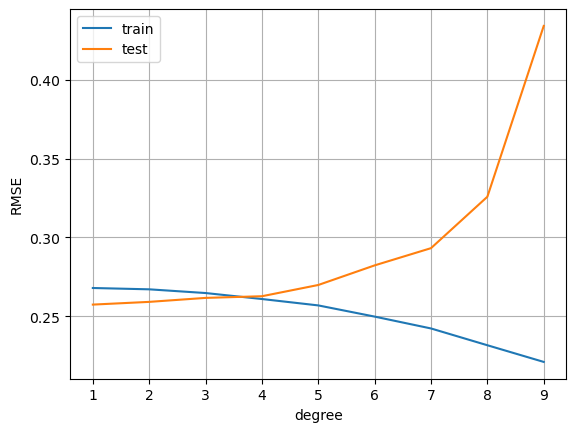

In [69]:
def get_rmse(y, y_fit):
    return np.sqrt(mean_squared_error(y, y_fit))

rmse_df = pd.DataFrame(columns=["degree", "rmse_train", "rmse_test"])

for i in range(1, 10):

    # add polynomial features
    poly = PolynomialFeatures(degree=i, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)
    
    model = LinearRegression()
    model.fit(x_train_poly, y_train)

    y_train_pred = model.predict(x_train_poly)
    y_test_pred = model.predict(x_test_poly)
    
    rmse_df.loc[i - 1] = [i,
                          get_rmse(y_train, y_train_pred),
                          get_rmse(y_test, y_test_pred)]

plt.plot(rmse_df['degree'], rmse_df['rmse_train'], label='train')
plt.plot(rmse_df['degree'], rmse_df['rmse_test'], label='test')
plt.xlabel('degree')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

Before performing regression to predict the student grades, we first haev to decide the degree of polynomial to provide the most accurate prediction. 

Based on the graph above, as the degree of polynomial increases, RMSE (root mean suqared error) decreases for the train dataset indicating that the line is gradually increasing and become a better fit. On the other hand, the fit of the line to the test dataset worsens as indicated with the increasing RMSE. Normally, this line would form a U shape indicating a point of optimal degree, however in this case the optimal degree is 1 and has an exponential shape. 

Since from degree 1 to 3 test seems to increase at the largest rate compared to train, it shows that a moer complex curve may not add value and risk overfitting. Thus, degree 1 is the most optimal choice. 


In [70]:
# train linear regression model
reg_model = LinearRegression()
reg_model.fit(x_train, y_train)

# prediction
y_pred = reg_model.predict(x_test)
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted GPA'])

x_grade_class = x_test.join(student_list_clean[['GradeClass']], how='inner')
df_joined = pd.concat([x_grade_class.reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df], axis=1)
df_joined['Error'] = df_joined['GPA'] - df_joined['Predicted GPA']

# prediction result
print("RMSE:", np.sqrt((mean_squared_error(y_test, y_pred))))
df_joined

RMSE: 0.2573806214763122


,Age,StudyTimeWeekly,Absences,ParentalSupport,GradeClass,GPA,Predicted GPA,Error
0,18,17.875484,21,0,F,1.217335,1.171218,0.046117
1,18,5.969013,0,3,A,3.512323,3.342788,0.169535
2,17,1.754353,24,2,F,0.184251,0.719120,-0.534868
3,15,13.177108,25,2,F,0.835990,0.970085,-0.134095
4,16,19.441069,16,4,D,2.461047,2.324583,0.136464
...,...,...,...,...,...,...,...,...
415,15,16.409226,2,1,B,3.399543,3.179270,0.220273
416,18,8.003105,14,3,D,2.069758,2.022749,0.047009
417,18,8.619661,18,1,F,1.146086,1.348803,-0.202717
418,17,7.598486,15,2,F,1.559595,1.773827,-0.214233


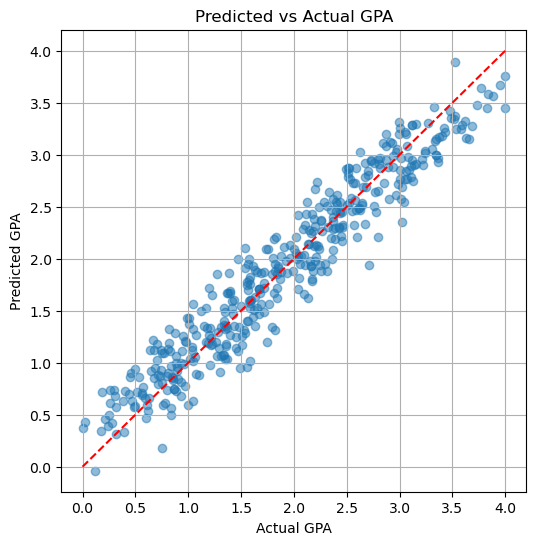

In [71]:
plt.figure(figsize=(6, 6))
plt.scatter(df_joined['GPA'], df_joined['Predicted GPA'], alpha=0.5)
plt.plot([0, 4], [0, 4], 'r--')

plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title('Predicted vs Actual GPA')
plt.grid(True)
plt.show()

Based on the results, the regression model we have trained is approximately 0.2573 GPA points away from the actual GPA as indicated by the RSME value of 0.2573. Given that GPA ranges from 0 to 4, the level of error is relatively low which indicates that our model performed well in capturing the underlying patterns within the student's age, weekly student time, number of absences, and the level of parential support. 

This model would be great in providing students to better predict their GPA based on their currnet study habits and situations as well as providing teachers with identifying students who are more at risk of falling behind. 

ALthough the model is relatively accurate, there is room for improvments. Accurancy and precision could be further refined through several means such as exploring more complex models, feature engineering and hyperparameter tuning. 

In [72]:
def grade_calc(row):
    gpa = row['Predicted GPA']
    if gpa >= 3.5:
        return 'A'
    elif 3.0 <= gpa < 3.5:
        return 'B'
    elif 2.5 <= gpa < 3.0:
        return 'C'
    elif 2.0 <= gpa < 2.5:
        return 'D'
    else:
        return 'F'
    
# Apply the function to each row of the DataFrame
df_joined.loc[:,'PredictedGradeClass'] = df_joined.apply(grade_classifier, axis=1)
df_joined

# calculate accuracy 
accuracy = accuracy_score(df_joined['GradeClass'], df_joined['PredictedGradeClass'])
print("Accuracy:", accuracy)


Accuracy: 1.0


The conversion of the predicted grade to the corresponding letter grade, the results matched perfectly with the actual grade as shown with an accuracy of 1.0.

## Conclusion

In this notebook, we aim not only aim to create a predictive model to predict student performace based on certain variables, but also to determine which algorithm - SVM, random forest, and regression-to-letter-grade - works best in this context. The data cleaning stage involves removing outliers, handle missing values, mapping numeric grade to letter grade, and ensuring the correct grade is mapped to the correct student score. 

1. Between SVM and random forest, SVM performed the best as demonstrated with it having a better accuracy score in the context of predicting student grades.

2. By implimenting a regression model with a low RMSE value, we are able to predict the GPA scores of students accurately which when converted to letter grade, we were able to achieve a perfect accuracy score. Thus, the regression model out performed the classification model. This is the case as regression models works with continuous data and are able to capture subtle differences in student GPA unlike classification models which predicts discrete categories where it's harder. 

